# <center> Pipelines, Serialization </center> 

In [8]:
import pandas as pd
import numpy as np

# Пара библиотек для визуализации
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier
import xgboost
import catboost

# from IPython.core.display import display, HTML
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

import seaborn as sns

# Импорт Данных

In [9]:
file_path = 'https://raw.githubusercontent.com/a-milenkin/Datasetes_for_Piplines/main/responses.csv'
data = pd.read_csv(file_path)

<div class="alert alert-info">

<b>Про датасет </b>


    
Приведеные результаты опроса молодежи до 21-го года по тому, какие вещи делют их счастливыми по 5-й шкале
    
</div>


<div class="alert alert-info">

<b>Про Задачу </b>

Попробуем классифицировать людей по оценкам уровня счастья
    
</div>


In [11]:
interesting_features = ["Happiness in life", "Age", "Height", "Gender", "Weight", 
              "Left - right handed", "Village - town", "Getting up", "God",
              "Health", "Borrowed stuff", "Self-criticism", "Elections", 
              "Smoking", "Alcohol" ,"Number of friends", "Spending on healthy eating",
              "Music", "Movies", "Friends versus money", "Changing the past"]


target = ["Happiness in life"]

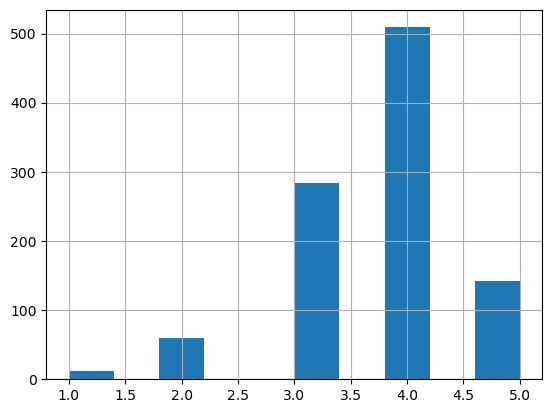

In [12]:
data["Happiness in life"].hist();

In [13]:
# Посмотрим пропуски в целевой переменной
data["Happiness in life"].isnull().sum()

4

In [14]:
# Посмотрим какие типы переменных у нас есть
data.dtypes.value_counts()

float64    134
object      11
int64        5
Name: count, dtype: int64

In [15]:
# Возмем только часть переменных (для простоты рассмотрения)
data = data[interesting_features]

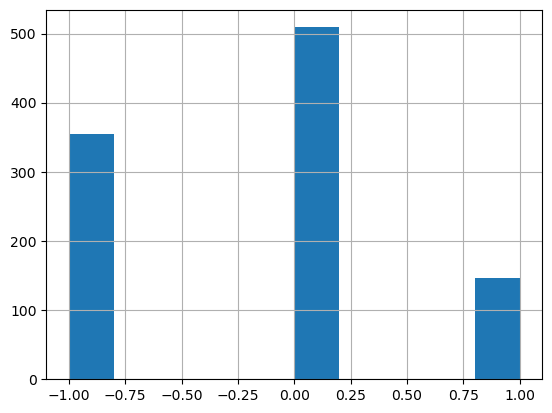

In [16]:
# Сбалансируем классы

def happiness_score(x):
    if x < 4:
        return -1
    elif x == 4.0:
        return 0
    else:
        return 1
    
data["Happiness in life"] = data["Happiness in life"].apply(happiness_score)

data["Happiness in life"].hist();

# Есть ли в данных выбросы? Есть почти всегда!

In [19]:
data.isnull().sum()

Happiness in life              0
Age                            7
Height                        20
Gender                         6
Weight                        20
Left - right handed            3
Village - town                 4
Getting up                     5
God                            2
Health                         1
Borrowed stuff                 2
Self-criticism                 5
Elections                      3
Smoking                        8
Alcohol                        5
Number of friends              0
Spending on healthy eating     2
Music                          3
Movies                         6
Friends versus money           6
Changing the past              2
dtype: int64

In [20]:
# Уберем выбросы. В этом месте может быть более интеллектуальный анализ пропусков. Возможно построение отдельных моделей для заполнения пропусков в каждой переменной.
data.dropna(inplace=True)

In [21]:
# Разделим на обучайющий и тестовый датасеты

data_train, data_test = train_test_split(data, test_size=0.2, stratify=data[target])

print(data_train.shape, data_test.shape)

(740, 21) (185, 21)


In [22]:
data.head()

,Happiness in life,Age,Height,Gender,Weight,Left - right handed,Village - town,Getting up,God,Health,...,Self-criticism,Elections,Smoking,Alcohol,Number of friends,Spending on healthy eating,Music,Movies,Friends versus money,Changing the past
0,0,20.0,163.0,female,48.0,right handed,village,2.0,1.0,1.0,...,1.0,4.0,never smoked,drink a lot,3,3.0,5.0,5.0,3.0,1.0
1,0,19.0,163.0,female,58.0,right handed,city,5.0,1.0,4.0,...,4.0,5.0,never smoked,drink a lot,3,2.0,4.0,5.0,4.0,4.0
2,0,20.0,176.0,female,67.0,right handed,city,4.0,5.0,2.0,...,4.0,5.0,tried smoking,drink a lot,3,2.0,5.0,5.0,5.0,5.0
3,-1,22.0,172.0,female,59.0,right handed,city,1.0,4.0,1.0,...,5.0,5.0,former smoker,drink a lot,1,1.0,5.0,5.0,2.0,5.0
4,-1,20.0,170.0,female,59.0,right handed,village,4.0,5.0,3.0,...,5.0,5.0,tried smoking,social drinker,3,4.0,5.0,5.0,3.0,4.0


# Какие признаки в данных?

In [23]:
numerical_features = ['Age', 'Height', 'Weight']  # Численные переменные

# Бинарные признаки
to_dummies = [
    'Gender', 'Left - right handed', 'Village - town', 'Smoking',  "Alcohol" ,
]

# Категориальные признаки
categorical_features = [
    col for col in data.columns if col not in numerical_features + target + to_dummies
]

all_features = categorical_features + numerical_features
len(all_features)

15

<div class="alert alert-info">

Pipeline позволяет обернуть сразу несколько этапов обработки данных в один объект

- **FunctionTransformer**: преобразует функцию в трансформер
- **FeatureUnion**: объединяет результаты нескольких трансформеров в один датасет
- **ColumnTransformer**: выбирает определенные колонки
- **make_pipeline**: удобная обертка для создания пайплайна, можно использовать вместо Pipeline 

In [39]:
#   Для категориальных - применяем SimpleImputer, а затем StandardScaler
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("fs", SelectKBest(score_func=f_classif, k="all")),
])

#   Для категориальных - применяем SimpleImputer, а затем OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

# Собираем воедино трансформеры для числовых и категориальных признаков
data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features),
])

# Создание конвейера препроцессора, который сначала преобразует данные
preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression())])

classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['Age',
                                                                    'Height',
                                                                    'Weight']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Getting '
                                                                    'up',
                                                                    'God',
                                                                    'Health',
                                                                    'Borrowed '
                                                                    'stuff',
                                                                    'Self-criticism',
                                                                    'Elections',
                                                                    'Number of '
                                                                    'friends',
                                                                    'Spending '
                                                                    'on '
                                                                    'healthy '
                                                                    'eating',
                                                                    'Music',
                                                                    'Movies',
                                                                    'Friends '
                                                                    'versus '
                                                                    'money',
                                                                    'Changing '
                                                                    'the '
                                                                    'past'])]))])),
                ('classifier', LogisticRegression())])

In [40]:
# data_train, data_test = train_test_split(data[all_features + target], test_size=0.2, stratify=data[target])
# print(data_train.shape, data_test.shape)

(740, 16) (185, 16)


In [41]:

# classifier_pipline.fit(data_train[all_features], data_train[target])

# preds = classifier_pipline.predict(data_test[all_features])

# print(classification_report(data_test[target], preds))

              precision    recall  f1-score   support

          -1       0.48      0.37      0.42        65
           0       0.57      0.71      0.63        93
           1       0.58      0.41      0.48        27

    accuracy                           0.55       185
   macro avg       0.54      0.50      0.51       185
weighted avg       0.54      0.55      0.53       185



# А как подбирать параметры у этой всей махины??

In [42]:
f1 = make_scorer(f1_score, average="macro")

In [43]:
classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['Age',
                                                                    'Height',
                                                                    'Weight']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Getting '
                                                                    'up',
                                                                    'God',
                                                                    'Health',
                                                                    'Borrowed '
                                                                    'stuff',
                                                                    'Self-criticism',
                                                                    'Elections',
                                                                    'Number of '
                                                                    'friends',
                                                                    'Spending '
                                                                    'on '
                                                                    'healthy '
                                                                    'eating',
                                                                    'Music',
                                                                    'Movies',
                                                                    'Friends '
                                                                    'versus '
                                                                    'money',
                                                                    'Changing '
                                                                    'the '
                                                                    'past'])]))])),
                ('classifier', LogisticRegression())])

In [44]:
param_grid = {
    'classifier__C': np.logspace(-5, 2, 200), # np.linspace(-10, 10)
    'classifier__penalty': ['l2'],
    'classifier__class_weight': ['balanced', None],
    
    'preprocessor__data_transformer__numerical__imputer__strategy':['median', 'mean']
}


search = GridSearchCV(classifier_pipline, param_grid, n_jobs=1, cv=3 , scoring=f1)

search.fit(data_train.drop(target, axis=1), data_train[target].values.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('scaler',
                                                                                                           StandardScaler()),
                                                                                                          ('fs',
                                                                                                           SelectKBest(k='all'))]),
                                                                                          ['Age',
                                                                                           'Height',
                                                                                           'Weight']),
                                                                                         ('categorical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('onehot',
                                                                                                           OneHotEncod...
       4.10265811e+01, 4.44878283e+01, 4.82410870e+01, 5.23109931e+01,
       5.67242607e+01, 6.15098579e+01, 6.66991966e+01, 7.23263390e+01,
       7.84282206e+01, 8.50448934e+01, 9.22197882e+01, 1.00000000e+02]),
                         'classifier__class_weight': ['balanced', None],
                         'classifier__penalty': ['l2'],
                         'preprocessor__data_transformer__numerical__imputer__strategy': ['median',
                                                                                          'mean']},
             scoring=make_scorer(f1_score, average=macro))

<div class="alert alert-info">

Нам даже не нужно теперь делить на `train` и `test`, ведь есть кросс-валидация 

In [45]:
search.best_params_

{'classifier__C': 0.27049597304631373,
 'classifier__class_weight': None,
 'classifier__penalty': 'l2',
 'preprocessor__data_transformer__numerical__imputer__strategy': 'median'}

In [46]:
search.best_score_

0.48564966255097336

# Еще раз, но по шагам!

In [47]:
classifier_pipline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', LogisticRegression())])

In [48]:
# Создание конвейера препроцессора, который сначала преобразует данные.
preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])


# Собираем воедино трансформеры для числовых и категориальных признаков
data_transformer = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numerical_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

In [49]:
#   Для категориальных - применяем SimpleImputer, а затем StandardScaler

numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("fs", SelectKBest(score_func=f_classif, k="all")),
    ]
)

In [50]:
#   Для категориальных - применяем SimpleImputer, а затем OneHotEncoder
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)


classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['Age',
                                                                    'Height',
                                                                    'Weight']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Getting '
                                                                    'up',
                                                                    'God',
                                                                    'Health',
                                                                    'Borrowed '
                                                                    'stuff',
                                                                    'Self-criticism',
                                                                    'Elections',
                                                                    'Number of '
                                                                    'friends',
                                                                    'Spending '
                                                                    'on '
                                                                    'healthy '
                                                                    'eating',
                                                                    'Music',
                                                                    'Movies',
                                                                    'Friends '
                                                                    'versus '
                                                                    'money',
                                                                    'Changing '
                                                                    'the '
                                                                    'past'])]))])),
                ('classifier', LogisticRegression())])

# А если вдруг одной модели мало?

In [51]:
clf1 = LogisticRegression(multi_class="multinomial", random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

blending_classifier = VotingClassifier(
    estimators=[("log_regrassion", clf1), 
                ("random_forest", clf2), 
                ("gnb", clf3)] 
)
blending_classifier

VotingClassifier(estimators=[('log_regrassion',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('random_forest',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('gnb', GaussianNB())])

In [52]:
classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", blending_classifier)]
)

classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['Age',
                                                                    'Height',
                                                                    'Weight']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))...
                                                                    'Elections',
                                                                    'Number of '
                                                                    'friends',
                                                                    'Spending '
                                                                    'on '
                                                                    'healthy '
                                                                    'eating',
                                                                    'Music',
                                                                    'Movies',
                                                                    'Friends '
                                                                    'versus '
                                                                    'money',
                                                                    'Changing '
                                                                    'the '
                                                                    'past'])]))])),
                ('classifier',
                 VotingClassifier(estimators=[('log_regrassion',
                                               LogisticRegression(multi_class='multinomial',
                                                                  random_state=1)),
                                              ('random_forest',
                                               RandomForestClassifier(n_estimators=50,
                                                                      random_state=1)),
                                              ('gnb', GaussianNB())]))])

# А что если хотим использовать стекинг?

In [54]:
# получим список эстиматоров
estimators = [
    ("Random_Forest", RandomForestClassifier()),
    ("Xgboost", xgboost.XGBClassifier()),
    ("SVM", LinearSVC()),
    
]

# построим классификатор используя стекинг и наш список классификаторов
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(n_jobs=-1, verbose=True),
    n_jobs=-1,
    verbose=True,
)

In [55]:
stacking_classifier

StackingClassifier(estimators=[('Random_Forest', RandomForestClassifier()),
                               ('Xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_t...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('SVM', LinearSVC())],
                   final_estimator=LogisticRegression(n_jobs=-1, verbose=True),
                   n_jobs=-1, verbose=True)

In [56]:
# получим список эстиматоров
estimators = [
    ("Random_Forest", RandomForestClassifier()),
    ("SVM", LinearSVC()),
    ("Xgboost", xgboost.XGBClassifier()),
]

# построим классификатор используя стекинг и наш список классификаторов
stacking_classifier = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(n_jobs=-1), n_jobs=-1
)

classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", stacking_classifier)]
)

classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   ['Age',
                                                                    'Height',
                                                                    'Weight']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))...
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...))],
                                    final_estimator=LogisticRegression(n_jobs=-1),
                                    n_jobs=-1))])

# Чуть более хитрый стекинг/блендинг моделей

In [57]:
from sklearn.decomposition import PCA

# получим список эстиматоров
estimators = [
    ("SVM", make_pipeline(preprocessor, PCA(), LinearSVC())),
    ("Random_Forest", make_pipeline(preprocessor, RandomForestClassifier())),
    ("Xgboost", make_pipeline(preprocessor, xgboost.XGBClassifier())),
]

# построим классификатор используя стекинг и наш список классификаторов
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(n_jobs=-1, verbose=True),
    n_jobs=-1,
    verbose=True,
)

stacking_classifier

StackingClassifier(estimators=[('SVM',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('data_transformer',
                                                                  ColumnTransformer(transformers=[('numerical',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer()),
                                                                                                                   ('scaler',
                                                                                                                    StandardScaler()),
                                                                                                                   ('fs',
                                                                                                                    SelectKBest(k='all'))]),
                                                                                                   ['Age',
                                                                                                    'Height',
                                                                                                    'Weight']),
                                                                                                  ('categorical',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer()),
                                                                                                                   ('onehot',
                                                                                                                    OneHo...
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...))]))],
                   final_estimator=LogisticRegression(n_jobs=-1, verbose=True),
                   n_jobs=-1, verbose=True)

# А сколько всего кода было написано?

In [58]:
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("feature_selector", SelectKBest(score_func=f_classif, k="all"))])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features)])

preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

estimators = [
    ("SVM", make_pipeline(preprocessor, LinearSVC(dual="auto"))),
    ("Random_Forest", make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1))),
    ("xgboost", make_pipeline(preprocessor, xgboost.XGBClassifier(n_jobs=-1)))
    ]

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(n_jobs=-1, verbose=False),
    n_jobs=1,
    verbose=True,
)

In [59]:
stacking_classifier

StackingClassifier(estimators=[('SVM',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('data_transformer',
                                                                  ColumnTransformer(transformers=[('numerical',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer()),
                                                                                                                   ('scaler',
                                                                                                                    StandardScaler()),
                                                                                                                   ('feature_selector',
                                                                                                                    SelectKBest(k='all'))]),
                                                                                                   ['Age',
                                                                                                    'Height',
                                                                                                    'Weight']),
                                                                                                  ('categorical',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer()),
                                                                                                                   (...
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=-1,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...))]))],
                   final_estimator=LogisticRegression(n_jobs=-1, verbose=False),
                   n_jobs=1, verbose=True)

# Обучении махины - Будет ли легко?

In [60]:
stacking_classifier.fit(data[interesting_features], data[target])

StackingClassifier(estimators=[('SVM',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('data_transformer',
                                                                  ColumnTransformer(transformers=[('numerical',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer()),
                                                                                                                   ('scaler',
                                                                                                                    StandardScaler()),
                                                                                                                   ('feature_selector',
                                                                                                                    SelectKBest(k='all'))]),
                                                                                                   ['Age',
                                                                                                    'Height',
                                                                                                    'Weight']),
                                                                                                  ('categorical',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer()),
                                                                                                                   (...
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=-1,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...))]))],
                   final_estimator=LogisticRegression(n_jobs=-1, verbose=False),
                   n_jobs=1, verbose=True)

In [61]:
preds = stacking_classifier.predict(data[interesting_features])

print(classification_report(data[target], preds))

              precision    recall  f1-score   support

          -1       0.92      0.90      0.91       324
           0       0.94      1.00      0.97       467
           1       0.98      0.81      0.89       134

    accuracy                           0.94       925
   macro avg       0.95      0.90      0.92       925
weighted avg       0.94      0.94      0.94       925



# Гибкость паплайна

In [62]:
# Мы можем получть любой параметр из пайплайна
stacking_classifier.estimators[0][1][0].steps[0][1].transformers[0][1].steps[2][1].k

'all'

# Как сохранить всю эту махину?

In [63]:
# Для сериализации моделей
import pickle

In [64]:
with open("owesome_pipeline.pkl", "wb") as f:
    pickle.dump(stacking_classifier, f)